# Map of NZ using Geodetic Markers

Inspiration for this project began earlier this month. I was on a small family holiday in [Mt. Maunganui](https://www.newzealand.com/int/mount-maunganui/). Of the many activites to do, we embarked on climbing [Mauao](https://en.wikipedia.org/wiki/Mount_Maunganui_(mountain)).

At the summit, not only are your welcomed by a stunning view of the beachside township, but a tall out-of-place structure known as a *Geodetic marker*, more specifically a trig station.

Below is a plaque on the exact trig station located at the top of Mauao:

<img src="trig-photo.jpg">

And this inspired me for this project. With a whole data bank of these markers, their locations and their heights, can we map them and colour them by altitude?

And this is what we plan to do for this following project.

[Here is the link to the Github for the code](https://github.com/ShivanS93/MapOfNZ).

### Learning Points

Before we get stuck in, we will have a look at some learning points, which this post will provide.
* How to use `pandas` to load `.csv` data
* Using `matplotlib` and its funcionality
* `pandas` groupby method and aggregation
* Using `seaborn` as a method to graph in conjunction with `matplotlib`

### How to access the data

The [Koordinates website](https://koordinates.com/) holds most of the geospatial data of New Zealand.  We will require to create an account to access the data for this project. Thankfully, it doesn't cost a cent.

We can search for [NZ Geodetic Vertical Marks](https://koordinates.com/from/data.linz.govt.nz/layer/50784/). This data is curated by the members of [Land Information New Zealand website](https://www.linz.govt.nz/). Selecting *Vertical Marks* gives us heights in a particular format.

When it comes to heights, a simple measurement isn't that simple.

Without getting into too much detail, vertical datums resemble what is known as *normal-orthometric heights*. This is what we are most familiar with as height above sea level. Normal-orthometric height is actually the mean/average heights at sea level (as sea level can change with tide).

This is opposed to *ellipsoidal heights*, which approximates Earth as an ellipsoid shape and uses this as a point of reference.

[The LINZ website goes into this with more detail](https://www.linz.govt.nz/data/geodetic-system/datums-projections-and-heights/vertical-datums).

### Import libraries and load data

In [1]:
import pandas as pd
import numpy as np

#import random as r

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.lines import Line2D

import seaborn as sns

%matplotlib inline

Here we can use `!` which evokes a magic function. In the following case, we are using a linux command, `ls` to list files in a directory, `./files`.

We will use the `.csv` files and load this into a pandas dataframe.

In [2]:
# find the name of the .csv file containing the data
!ls ./files

nz-geodetic-vertical-marks.csv	 nz-geodetic-vertical-marks.txt
nz-geodetic-vertical-marks.csvt  nz-geodetic-vertical-marks.vrt
nz-geodetic-vertical-marks.prj	 nz-geodetic-vertical-marks.xml


In [3]:
# load into dataframe
geomarks = pd.read_csv('files/nz-geodetic-vertical-marks.csv')
geomarks

,WKT,id,nod_id,geodetic_code,current_mark_name,description,mark_type,beacon_type,mark_condition,order,land_district,normal_orthometric_height,coordinate_system,shape_X,shape_Y
0,POINT (170.1231392333 -45.5075203333),51299,43867984,ER1Y,D 536 (MOW),NaN,Unknown,Unknown,Not Specified,3V,Otago,203.035810,Dunedin Vertical Datum 1958,170.123139,-45.507520
1,POINT (173.88769725 -41.5102878833),91863,42140513,DMTQ,BLK 1 SO 5466,Round bronze L&S plaque set in concrete flush ...,Pin,Not Beaconed,Reliably Placed/Found,3V,Marlborough,22.628000,New Zealand Vertical Datum 2016,173.887697,-41.510288
2,POINT (169.97478893333 -44.45716235),51600,43868028,ER0K,D 30 (MOW),NaN,Unknown,Unknown,Not Specified,2V,Otago,424.519034,Lyttelton Vertical Datum 1937,169.974789,-44.457162
3,POINT (169.68062805 -45.04893815),51307,43868010,ER15,D 384 (MOW),NaN,Unknown,Unknown,Not Specified,2V,Otago,337.167394,Dunedin Vertical Datum 1958,169.680628,-45.048938
4,POINT (169.2920531 -44.6390015167),15763,36745863,B3TC,D 498 (MOW),SS PIN SET IN CONCRETE. 5 FT TO POST.,Other,Not Beaconed,Mark Found,1V,Otago,338.372760,Dunedin Vertical Datum 1958,169.292053,-44.639002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105578,POINT (166.9518698 -45.2651755667),105636,47827789,SCTY,Secretary Island,Continuously operating GNSS CORS site operated...,Unknown,NaN,Not Specified,2V,NaN,1193.889700,New Zealand Vertical Datum 2016,166.951870,-45.265176
105579,POINT (172.5616037 -43.6548353167),5876,36731213,BCTR,IT III DP 30398,IT III DP 30398 was upgraded to a SS Pin in co...,Pin,NaN,Reliably Placed/Found,5V,Canterbury,7.556697,Mean Sea Level,172.561604,-43.654835
105580,POINT (172.5616037 -43.6548353167),50967,36731213,BCTR,IT III DP 30398,IT III DP 30398 was upgraded to a SS Pin in co...,Pin,NaN,Reliably Placed/Found,1V,Canterbury,7.351509,Lyttelton Vertical Datum 1937,172.561604,-43.654835
105581,POINT (172.5616037 -43.6548353167),56057,36731213,BCTR,IT III DP 30398,IT III DP 30398 was upgraded to a SS Pin in co...,Pin,NaN,Reliably Placed/Found,2V,Canterbury,7.112400,New Zealand Vertical Datum 2016,172.561604,-43.654835


Here we have the data loaded into a pandas dataframe. Let's explore the data some more.

In [4]:
# explore the data more
geomarks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105583 entries, 0 to 105582
Data columns (total 15 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   WKT                        105583 non-null  object 
 1   id                         105583 non-null  int64  
 2   nod_id                     105583 non-null  int64  
 3   geodetic_code              105583 non-null  object 
 4   current_mark_name          105583 non-null  object 
 5   description                73350 non-null   object 
 6   mark_type                  105583 non-null  object 
 7   beacon_type                93424 non-null   object 
 8   mark_condition             87315 non-null   object 
 9   order                      105583 non-null  object 
 10  land_district              105295 non-null  object 
 11  normal_orthometric_height  105583 non-null  float64
 12  coordinate_system          105583 non-null  object 
 13  shape_X                    10

### Exploring the Data

We can see there are a total of 105,582 entries.

The important features (input variables) are `shape_X`, `shape_Y`, which resemble longitude and latitude, and `normal_orthometric_height`, which is the height. These are all accounted for with no missing values.

Using `shape_X` and `shape_Y`, we can actually plot this out to represent geographic space. This has probably done countless times before but when I found this out in Aurélien Géron's book *Hands On Machine Learning, 2nd edition*, it blew my mind!

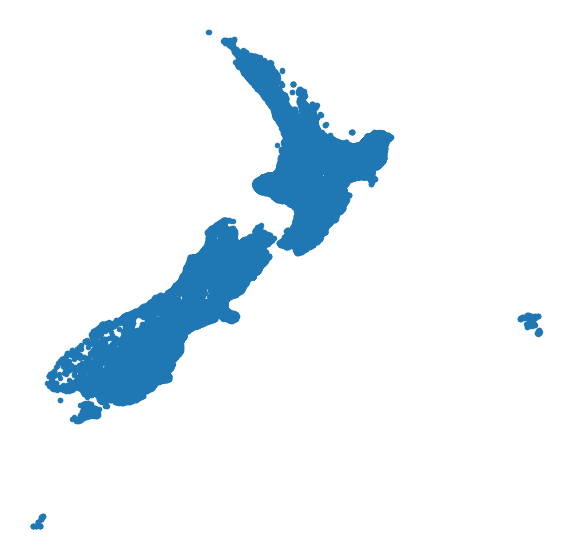

In [17]:
mapNZ = geomarks.plot(kind='scatter', x='shape_X', y='shape_Y',  figsize=(10,10))
ax = plt.axis('off')

Look familiar? 

It's New Zealand!

There are so many markers, 105,582 to be exact. So, let's reduce the size of the markers. We can alter parameters:
* `alpha` - this is the opacity of the marker
* `s` - size of the marker

and this will allow us to see the individual markers a lot more easier.

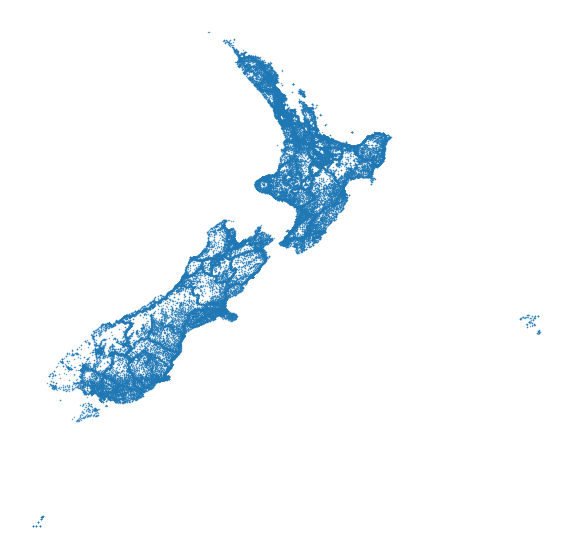

In [19]:
mapNZ = geomarks.plot(kind='scatter', x='shape_X', y='shape_Y', 
                       figsize=(10,10), alpha=0.8, s=0.2)
ax = plt.axis('off')

Now we can apply a color based on vertical height.

There important parameters are:
* `c` - this is colours of the points
* `cmap` - this provides the colour scheme; we will be using `jet`

Utilising these parameters will create another dimention to our graph.

We have also altered the size of the markers by the height as well to emphasise this attribute. We divide by 100 for obvious scaling.


/home/shivan/miniconda3/envs/shivan_env/lib/python3.7/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


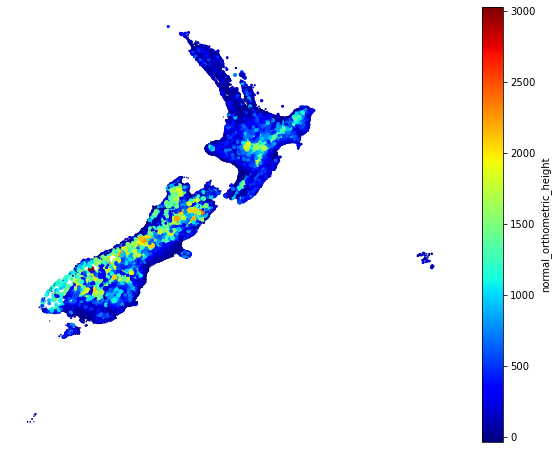

In [24]:
mapNZ = geomarks.plot(kind='scatter', x='shape_X', y='shape_Y', 
                            figsize=(10,8), s=geomarks['normal_orthometric_height']/100,
                            c='normal_orthometric_height', cmap=plt.get_cmap('jet'), colorbar=True)

ax = plt.axis('off')

You may notice that the lower points are drowning out the higher ones despite varying the marker size by vertical height.

When we explore the vertical heights in a bit more detail, we can see that the majority are at the lower end. A plot shows the data is *tail heavy*.

In [8]:
heights = geomarks['normal_orthometric_height']
heights.describe()

count    105583.000000
mean        176.935780
std         280.401109
min         -34.179500
25%          17.300748
50%          56.743200
75%         223.130634
max        3029.710448
Name: normal_orthometric_height, dtype: float64

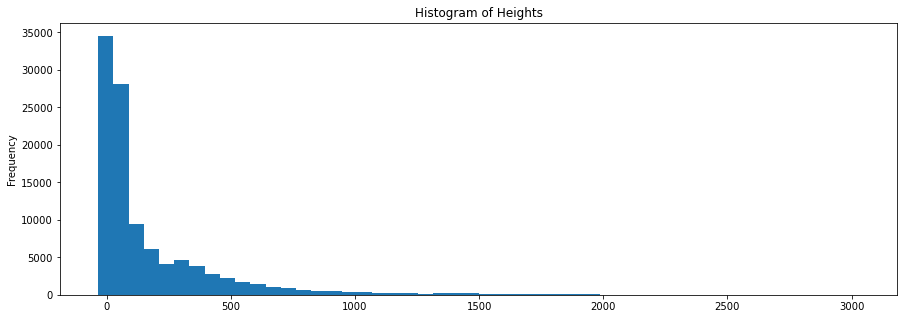

In [9]:
height_graphs = heights.plot(kind='hist', bins=50, figsize=(15,5), title='Histogram of Heights')

What we can then do is vary the alpha through the cmap. We take the cmap and change the alpha with the colder colours being associated with lower vertical heights also having lower alpha compared to warmer colour with greater heights.

/home/shivan/miniconda3/envs/shivan_env/lib/python3.7/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


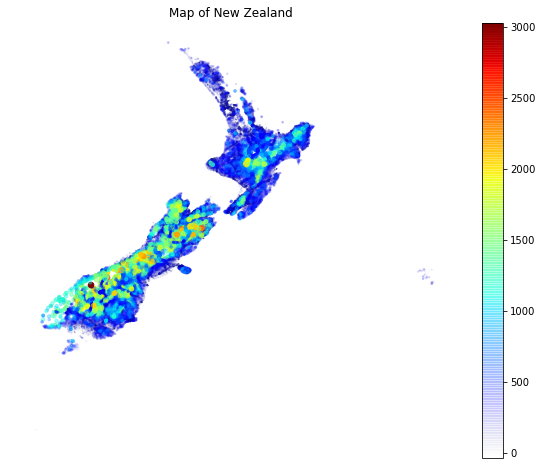

In [46]:
x = geomarks['shape_X']
y = geomarks['shape_Y']
c = geomarks['normal_orthometric_height']
s = geomarks['normal_orthometric_height']/100

cmap = plt.cm.jet
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:, -1] = np.linspace(0, 1, cmap.N)

my_cmap = ListedColormap(my_cmap)

plt.figure(figsize=(10,8))
plt.scatter(x, y, c=c, s=s, cmap=my_cmap)
plt.title("Map of New Zealand")
ax = plt.axis('off')
cbar = plt.colorbar()

And here we have our map that we intended to create.

But let's not stop there! Let's look at other aspects of the data.

You can see the dark red spot is the tallest of all the markers. This is [Mt Aspiring](https://en.wikipedia.org/wiki/Mount_Aspiring_/_Tititea), which is not New Zealand's highest summit, which does to Aoraki or Mt Cook.

In [45]:
# Top highest geodetic markers in New Zealand
geomarks.sort_values(by='normal_orthometric_height', ascending=False).head()

,WKT,id,nod_id,geodetic_code,current_mark_name,description,mark_type,beacon_type,mark_condition,order,land_district,normal_orthometric_height,coordinate_system,shape_X,shape_Y
42267,POINT (168.72778935 -44.3843282667),30534,36765982,AP41,MT ASPIRING,No station mark. Point observed is apparent ...,Other,Not Beaconed,NaN,5V,Westland,3029.710448,Mean Sea Level,168.727789,-44.384328
26438,POINT (173.66278935 -41.9958368167),13501,36743656,A41W,40 Tapuae-o-Uenuku,5 cm diameter iron tube set in rocks. Establis...,Other,Not Beaconed,Reliably Placed/Found,5V,Marlborough,2884.566663,Mean Sea Level,173.662789,-41.995837
40457,POINT (175.5625381833 -39.2893752),27028,36762269,A7WY,RUAPEHU,Trig is on highest point of Mt Ruapehu. Form...,Other,Not Beaconed,NaN,5V,Wellington,2796.530735,Mean Sea Level,175.562538,-39.289375
37498,POINT (175.5579165167 -39.2759168),17163,36747396,ALDB,H PARETETAITONGA,NaN,Other,Not Beaconed,NaN,5V,Wellington,2750.810778,Mean Sea Level,175.557917,-39.275917
30312,POINT (175.5728663167 -39.2737752667),23489,36756286,ALDC,D MATIHAO,NaN,Other,Not Beaconed,NaN,5V,Wellington,2663.333229,Mean Sea Level,175.572866,-39.273775


### Further Data Exploration

Let's look markers per district. Then, we can plot this data onto a bar chart.

In [11]:
geomarks['land_district'] = geomarks['land_district'].astype('str')
by_district = geomarks['land_district'].value_counts()
by_district

North Auckland    24125
South Auckland    15496
Wellington        12595
Canterbury        11741
Nelson             9129
Otago              8326
Gisborne           5765
Southland          4847
Hawkes Bay         4427
Taranaki           3092
Marlborough        2884
Westland           2868
nan                 288
Name: land_district, dtype: int64

We can see there are actually some hidden `nan`. [NaN stands for 'Not a Number'](https://en.wikipedia.org/wiki/NaN). It represents empty data.

We can reveal these `nan` by converting the column type to a string. We need to drop these for the following processing.

In [12]:
geomarks = geomarks[geomarks['land_district']!='nan']
by_district = geomarks['land_district'].value_counts()
by_district

North Auckland    24125
South Auckland    15496
Wellington        12595
Canterbury        11741
Nelson             9129
Otago              8326
Gisborne           5765
Southland          4847
Hawkes Bay         4427
Taranaki           3092
Marlborough        2884
Westland           2868
Name: land_district, dtype: int64

Here, the `nan` have been removed

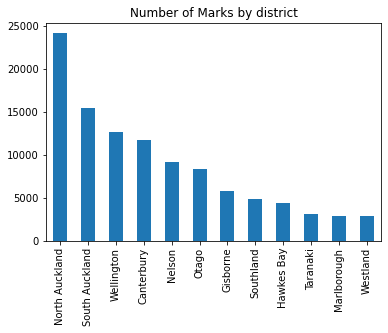

In [27]:
by_district.plot(kind='bar', title='Number of Marks by district')
plt.show()

Next, let's look at the average heights of each district. We do this using `groupby` and `agg` or aggregation. We will also drop extra columns to aid readability

In [14]:
district_group = geomarks.groupby('land_district') # groups data by district
district_means = district_group.agg(['mean', 'sem']) # 'sem' means standard error, sem = std / n ** (1/2)
district_means = district_means.drop(['id', 'nod_id', 'shape_X', 'shape_Y'], axis=1) # dropping extra columns for readability
district_means = district_means.sort_values(by=('normal_orthometric_height', 'mean'), ascending=False)
district_means

normal_orthometric_height          
                                    mean       sem
land_district                                     
Otago                         332.850194  4.127415
Canterbury                    229.991992  3.391722
Westland                      221.018163  7.699100
Southland                     218.923821  4.498254
Wellington                    209.669313  2.497936
Nelson                        205.110423  3.499999
Gisborne                      203.135954  3.662416
Marlborough                   196.972433  7.157678
Taranaki                      182.773013  3.082099
South Auckland                168.113852  1.585492
Hawkes Bay                    158.129201  3.535899
North Auckland                 55.950816  0.425008

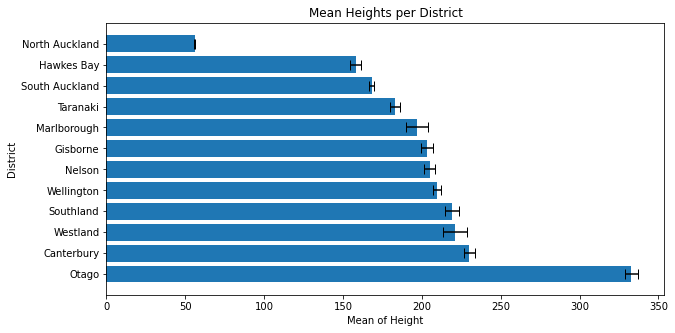

In [30]:
x = district_means[('normal_orthometric_height', 'mean')]
err = district_means[('normal_orthometric_height', 'sem')]

# notice how we call the tuple for a hierarchical column

plt.figure(figsize=(10,5))

plt.barh(y=x.index, width=x.values, xerr=err, capsize=5)

plt.title('Mean Heights per District')
plt.xlabel('Mean of Height')
plt.ylabel('District')
plt.show()

We can see that Otago on average as has the highest markers.

Let's go back to the New Zealand map. What we are going to do different is that we are going to plot points but use categorical colours. The colours will be based on district. And the colours will rank on average height of that district.

We will use `seaborn` colour pallet to create colour label, which will be evenly spaced RGB values.

We also have to create a custom legend using `Lin2D`

/home/shivan/miniconda3/envs/shivan_env/lib/python3.7/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


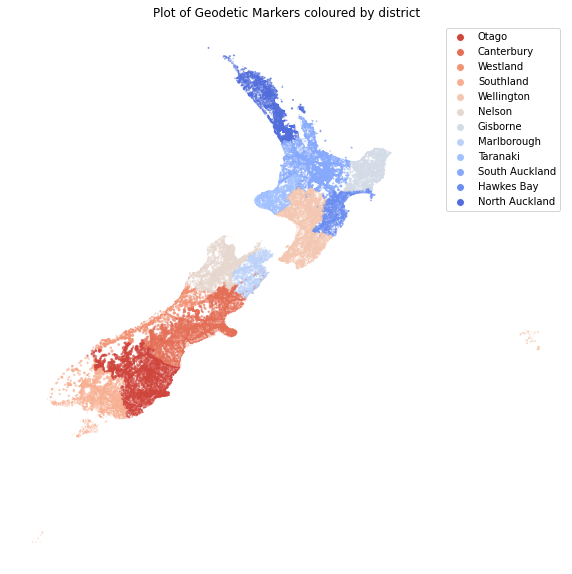

In [34]:
x = geomarks['shape_X']
y = geomarks['shape_Y']
s = geomarks['normal_orthometric_height'] / 500

plt.figure(figsize=(10,10))

colour_labels = list(district_means.index) # turns districts into a list
rgb_values = sns.color_palette('coolwarm_r', len(colour_labels)) # use seaborn to create colours, 
                                                                 # the number is based on the number of districts
colour_map = dict(zip(colour_labels, rgb_values)) # create a dict of district as keys and colours as values

legend_elements = [Line2D([0], [0], marker='o', color='w', markersize=8,
                          markerfacecolor=colour_map[label]) for label in colour_map] # creating a legend

NZ_d_map = plt.scatter(x, y, alpha=0.5, s=s, c=geomarks['land_district'].map(colour_map))
leg_ = plt.legend(legend_elements, colour_labels)
ax = plt.axis('off')
title_ = plt.title('Plot of Geodetic Markers coloured by district')

And there we have it, a map of New Zealand colour coded based on land district ranked by the average height of its markers.

### Conclusion

Walks and holidays are great for creating ideas. Here a simple walk up the Mount has sparked an idea to create a maps based on heights of the geodetic markers around New Zealand.

We used a variety of techniques - thanks to the Python libraries, `pandas`,`numpy`, `matplotlib`, and `seaborn` - to work with the data from [Koordinates](https://koordinates.com/) and [Land Information New Zealand (LINZ)](https://www.linz.govt.nz/).

We used this data to create a map of New Zealand colour coded based on the normal orthometric heights of the geodetic markers. In addition to this, we created another map based on the land districts, and this was ranked by the average heights of each district.

I hope you found this useful and I would be keen to hear what else could be done with this data. Please share this with anyone you might think would find this interesting.

### References

1. Mount Maunganui - Things to see and do - North Island | New Zealand. (n.d.). Www.Newzealand.com. https://www.newzealand.com/int/mount-maunganui/
2. Mount Maunganui (mountain). (2020, November 20). Wikipedia. https://en.wikipedia.org/wiki/Mount_Maunganui_(mountain)
3. Koordinates — Earth’s Data Platform. (n.d.). Koordinates.com. https://koordinates.com/
4. NZ Geodetic Vertical Marks. (n.d.). Koordinates.com. Retrieved December 11, 2020, from https://koordinates.com/from/data.linz.govt.nz/layer/50784/
5. Land Information New Zealand (LINZ). (n.d.). Land Information New Zealand (LINZ). https://www.linz.govt.nz/
6. Vertical datums. (n.d.). Land Information New Zealand (LINZ). Retrieved December 11, 2020, from https://www.linz.govt.nz/data/geodetic-system/datums-projections-and-heights/vertical-datums
7. (2019). Chapter 2: End-to-End Machine Learning Project [Review of Chapter 2: End-to-End Machine Learning Project]. In Hands on Machine Learning (pp. 35–84). O’Reily.
8. Python R. Plot With Pandas: Python Data Visualization for Beginners – Real Python. realpython.com. Accessed December 11, 2020. https://realpython.com/pandas-plot-python/
9. How to Normalize a Pandas DataFrame Column. CodeSpeedy. Published February 19, 2020. Accessed December 11, 2020. https://www.codespeedy.com/normalize-a-pandas-dataframe-column/
10. Abdishakur. (2020, April 29). How to make Value-By-Alpha Maps in Python. Retrieved from Medium website: https://towardsdatascience.com/how-to-make-value-by-alpha-maps-in-python-484722160490
11. Python Data Analysis Library — pandas: Python Data Analysis Library. Pydata.org. Published 2018. https://pandas.pydata.org/
12. Python Pandas - GroupBy - Tutorialspoint. www.tutorialspoint.com. Accessed December 14, 2020. https://www.tutorialspoint.com/python_pandas/python_pandas_groupby.htm
13. Matplotlib Scatter Plot Color by Category in Python. kanoki. Published August 30, 2020. Accessed December 15, 2020. https://kanoki.org/2020/08/30/matplotlib-scatter-plot-color-by-category-in-python/
14. Composing Custom Legends — Matplotlib 3.2.1 documentation. matplotlib.org. Accessed December 24, 2020. https://matplotlib.org/3.2.1/gallery/text_labels_and_annotations/custom_legends.html
15. Mount Aspiring / Tititea. Wikipedia. Published August 12, 2020. Accessed December 24, 2020. https://en.wikipedia.org/wiki/Mount_Aspiring_/_Tititea
